# Wikipedia Readability Analysis

*Nicholas Lines*

This notebook will explore the readability level of articles from Wikipedia and the Simplified English Wikipedia. These two encyclopedia databases provide us examples of technical and simplified formal English prose, largely free from publishing constraints beyond collective subjective opinions regarding the meaning of "simplified."

# Environment setup and imports

In [23]:
%pylab inline 
# for interactive plotting
import wikipedia # for collecting data
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot customization
from tqdm.notebook import tqdm # for progress bars
import pickle # to backup data
import pandas as pd # for tidy dataframes
from readability import Readability # for standard readability analysis
import seaborn as sns # supplemental plotting tools
import plotly.graph_objects as go # supplemental plotting tools
import plotly.express as px # supplemental plotting tools
from umap import UMAP # for UMAP dimensionality reduction (specifically for viewing projections)
import nltk # for NLP, particularly parts of speech tagging
from nltk.data import load
from sklearn.linear_model import Lasso, LogisticRegression # for feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # for data normalization
from sklearn.naive_bayes import GaussianNB # for classification
from sklearn.model_selection import cross_val_score # for model evaluation
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


The following functions will be used to simplify our work below.

In [24]:
def level_color_points(x, levels, colors):
    """Find color for each value in array x given a level coloring scheme
    
    The levels array must be sorted min to max (assured for matplotlib 
    contourf objects). 
    """
    # find the index of the largest value in levels smaller than x_i
    xcolors = []
    for x_i in x:
        if x_i >= levels[-1]:
            xcolors.append(colors[-1][0])
        else:
            j = argwhere(levels > x_i).min()
            xcolors.append(colors[j][0])
    return(xcolors)


def cl(x,y):
    """Coleman-Liau Index
    x is number of letters per 100 words
    y is number of sentences per 100 words
    """
    return 0.0588 * x - 0.296 * y - 15.8


def fks(x,y):
    """Flesch-Kincaid formula
    x is average number of syllables per word
    y is average number of words per sentence
    """
    return 0.39 * x + 11.8 * y - 15.59


def lr(p,s):
    """Linsear Write Score
    p is number of polysylabic words per 100 words
    s is number of sentences per 100 words
    """
    r = (100 + 2*p)/s
    if r>20:
        return r/2
    else:
        return r/2 - 1

# Analysis
## Example: Shakespeare
We'll consider a nice, simple example that shows the tendency of standard readability formulae/classifiers to disagree on complexity and even relative complexity ordering. We will compare a short sample of Shakespeare's writing (Jacques' "All the world's a stage" monologue from "As You Like It") with the simplified and standard Wikipedia entries for "Shakespeare."

In [25]:
wikipedia.set_lang("simple")
simple = wikipedia.page("William Shakespeare").content
wikipedia.set_lang("en")
standard = wikipedia.page("William Shakespeare").content
r_simple = Readability(simple)
r_standard = Readability(standard)

shakespeare_text = """All the world's a stage,
    And all the men and women merely players;
    They have their exits and their entrances;
    And one man in his time plays many parts,
    His acts being seven ages. At first the infant,
    Mewling and puking in the nurse's arms;
    Then the whining school-boy, with his satchel
    And shining morning face, creeping like snail
    Unwillingly to school. And then the lover,
    Sighing like furnace, with a woeful ballad
    Made to his mistress' eyebrow. Then a soldier,
    Full of strange oaths, and bearded like the pard,
    Jealous in honour, sudden and quick in quarrel,
    Seeking the bubble reputation
    Even in the cannon's mouth. And then the justice,
    In fair round belly with good capon lin'd,
    With eyes severe and beard of formal cut,
    Full of wise saws and modern instances;
    And so he plays his part. The sixth age shifts
    Into the lean and slipper'd pantaloon,
    With spectacles on nose and pouch on side,
    His youthful hose, well sav'd, a world too wide
    For his shrunk shank; and his big manly voice,
    Turning again toward childish treble, pipes
    And whistles in his sound. Last scene of all,
    That ends this strange eventful history,
    Is second childishness and mere oblivion;
    Sans teeth, sans eyes, sans taste, sans every thing."""

r_shakespeare = Readability(shakespeare_text)

shdf = pd.DataFrame()
shrs = [r_shakespeare, r_simple, r_standard]
names = ["Shakespeare", "Wiki Simple", "Wiki Standard"]
shdf["Text Sample"] = names
shdf["Dale-Chall Score"] = [r.dale_chall().score for r in shrs]
shdf["Dale-Chall Grade"] = [r.dale_chall().grade_levels for r in shrs]
shdf["ARI Score"] = [r.ari().score for r in shrs]
shdf["ARI Grade"] = [r.ari().grade_levels for r in shrs]
shdf["Coleman-Liau Score"] = [r.coleman_liau().score for r in shrs]
shdf["Coleman-Liau Grade"] = [r.coleman_liau().grade_level for r in shrs]
shdf["Spache Score"] = [r.spache().score for r in shrs]
shdf["Spache Grade"] = [r.spache().grade_level for r in shrs]
shdf["Linsear Write Score"] = [r.linsear_write().score for r in shrs]
shdf["Linsear Write Grade"] = [r.linsear_write().grade_level for r in shrs]
shdf["Flesch Score"] = [r.flesch().score for r in shrs]
shdf["Flesch Grade"] = [r.flesch().grade_levels for r in shrs]
shdf["Flesch-Kincaid Score"] = [r.flesch_kincaid().score for r in shrs]
shdf["Flesch-Kincaid Grade"] = [r.flesch_kincaid().grade_level for r in shrs]

These are the numeric results.

In [26]:
shdf

,Text Sample,Dale-Chall Score,Dale-Chall Grade,ARI Score,ARI Grade,Coleman-Liau Score,Coleman-Liau Grade,Spache Score,Spache Grade,Linsear Write Score,Linsear Write Grade,Flesch Score,Flesch Grade,Flesch-Kincaid Score,Flesch-Kincaid Grade
0,Shakespeare,8.788247,"[11, 12]",15.174461,[college_graduate],10.015472,10,7.948908,8,16.714286,17,61.166698,"[8, 9]",11.94876,12
1,Wiki Simple,9.860516,[college],10.133842,[11],11.185193,11,6.822199,7,11.095745,11,57.978873,"[10, 11, 12]",9.25615,9
2,Wiki Standard,10.775321,[college_graduate],14.638803,[college_graduate],12.679836,13,8.173530,8,16.604317,17,44.312586,[college],12.93982,13


In [20]:
compare = pd.DataFrame()
compare["Text Sample"] = shdf["Text Sample"]
samples = shdf["Text Sample"].to_list()
for col in list(shdf.columns):
    if "Grade" in col:
        col_name = col.split(" Grade")[0]
        scores = shdf[col_name + " Score"]
        vals = []
        for i in shdf[col]:
            if type(i)==list:
                i = i[-1]
            if i == "college":
                i = 13
            elif i == "college_graduate":
                i = 14
            vals.append(int(i))
        compare[col_name] = vals
        #print(len(samples), len(vals))
        #order = sorted(samples, key=lambda x:vals[samples.index(x)])
        #print(col_name, vals, order, scores)
compare

,Text Sample,Dale-Chall,ARI,Coleman-Liau,Spache,Linsear Write,Flesch,Flesch-Kincaid
0,Shakespeare,12,14,10,8,17,9,12
1,Wiki Simple,13,11,11,7,11,12,9
2,Wiki Standard,14,14,13,8,17,13,13


In [22]:
cap = "An example of grading inconsistencies between popular readability formulae. \
Three sample texts are provided, beginning with the All the World's a Stage monologue uttered \
by Jacques in As You Like It, Act II Scene VII. The second and third texts are the \
encyclopedia entries on William Shakespeare taken from the Simplified English and \
standard Wikipedia, respectively. The grades shown are the maximum grade predicted \
for each text by each formula. Grade 13 is considered college-level, and Grade 14 \
graduate level, etc."
lab = "Table 3"
print(compare.to_latex(caption=cap, label=lab, longtable=True, index=False))

\begin{longtable}{lrrrrrrr}
\caption{An example of grading inconsistencies between popular readability formulae. Three sample texts are provided, beginning with the All the World's a Stage monologue uttered by Jacques in As You Like It, Act II Scene VII. The second and third texts are the encyclopedia entries on William Shakespeare taken from the Simplified English and standard Wikipedia, respectively. The grades shown are the maximum grade predicted for each text by each formula. Grade 13 is considered college-level, and Grade 14 graduate level, etc.}
\label{Table 3}\\
\toprule
  Text Sample &  Dale-Chall &  ARI &  Coleman-Liau &  Spache &  Linsear Write &  Flesch &  Flesch-Kincaid \\
\midrule
\endfirsthead
\caption[]{An example of grading inconsistencies between popular readability formulae. Three sample texts are provided, beginning with the All the World's a Stage monologue uttered by Jacques in As You Like It, Act II Scene VII. The second and third texts are the encyclopedia entri

In [1194]:
predictors = [i for i in shdf.columns if "Score" in i]
orders = []
label_orders = []
for i in predictors:
    orders.append(shdf[["Text Sample", i]].sort_values(i, ascending=False)["Text Sample"].to_list())
    label_orders.append([i +" "+ j for j in shdf[["Text Sample", i]].sort_values(i, ascending=False)["Text Sample"].to_list()])

In [1195]:
orders

[['Wiki Standard', 'Wiki Simple', 'Shakespeare'],
 ['Shakespeare', 'Wiki Standard', 'Wiki Simple'],
 ['Wiki Standard', 'Wiki Simple', 'Shakespeare'],
 ['Wiki Standard', 'Shakespeare', 'Wiki Simple'],
 ['Shakespeare', 'Wiki Standard', 'Wiki Simple'],
 ['Shakespeare', 'Wiki Simple', 'Wiki Standard'],
 ['Wiki Standard', 'Shakespeare', 'Wiki Simple']]

In [1221]:
labels = array(label_orders).flatten()
llabels = array(orders).flatten()
source = []
target = []
x = array([[i * 1/len(orders)] * len(orders[0]) for i in range(len(orders))]).flatten()
y = array([i/len(orders[0]) for i in range(len(orders[0]))] * len(orders)).flatten()
for i in range(len(orders[0])):
    for j in range(len(orders) - 1):
        source.append( i + j * len(orders[0]))
        target.append(orders[j+1].index(llabels[i +  j * len(orders[0])]) + (j+1) * len(orders[0]))
value = ones(len(source))

Here is a figure that shows four of the most popular readability formulae's decision boundaries and the decisions made for our three example texts.

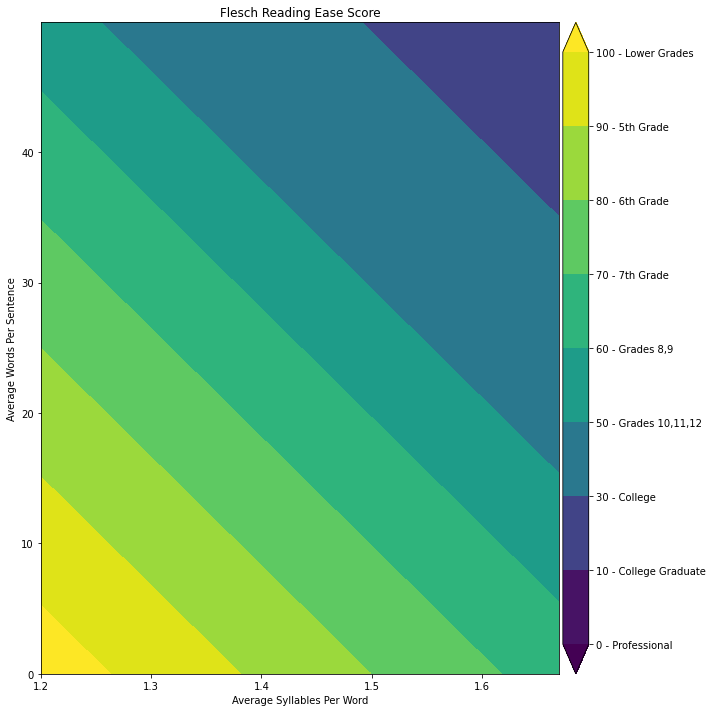

In [36]:
f, ax = subplots(nrows=1, ncols=1, figsize=(10,10))

b = np.arange(0,50,.05)
a = np.arange(1.2,1.68,.01)  
xa, yb = np.meshgrid(a,b, sparse=True)
z = -1.015 * yb - 84.6 * xa + 206.835
#z = -1*(-1.015 * yb - 84.6 * xa + 206.835) # inverted for plotting ease
c = ax.contourf(a,b,z,levels=[0,10,30,50,60,70,80,90,100],extend="both")
#c = ax[0][1].contourf(a,b,z,levels=[-100, -90, -80, -70, -60, -50, -30, -10, 0],extend="both")
divider = make_axes_locatable(ax)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(c, cax=cax2, orientation='vertical');
cbar.ax.set_yticklabels(["0 - Professional",
                         "10 - College Graduate",
                         "30 - College",
                         "50 - Grades 10,11,12",
                         "60 - Grades 8,9",
                         "70 - 7th Grade",
                         "80 - 6th Grade",
                         "90 - 5th Grade",
                         "100 - Lower Grades",
                         ])
# cbar.ax.set_yticklabels(["100 - Lower Grades",
#                          "90 - 5th Grade",
#                          "80 - 6th Grade",
#                          "70 - 7th Grade",
#                          "60 - Grades 8,9",
#                          "50 - Grades 10,11,12",
#                          "30 - College",
#                          "10 - College Graduate",
#                          "0 - Professional",
#                          ])
ax.set_xlabel("Average Syllables Per Word")
ax.set_ylabel("Average Words Per Sentence")
ax.set_title("Flesch Reading Ease Score");
# ax.scatter(x=[r_shakespeare.statistics()['avg_syllables_per_word']],
#     y=[r_shakespeare.statistics()['avg_words_per_sentence']], 
#     color="blue",
#     edgecolors="black", 
#     marker="d", 
#     label="Shakespeare sample");
# ax.scatter(x=[r_simple.statistics()['avg_syllables_per_word']],
#     y=[r_simple.statistics()['avg_words_per_sentence']], 
#     color="green",
#     edgecolors="black", 
#     marker="s", 
#     label="Simple Wikipedia entry on Shakespeare");
# ax.scatter(x=[r_standard.statistics()['avg_syllables_per_word']],
#     y=[r_standard.statistics()['avg_words_per_sentence']], 
#     color="red",
#     edgecolors="black", 
#     marker="o", 
#     label="Standard Wikipedia entry on Shakespeare");
f.tight_layout()
f.savefig("../IMAGES/Figure_1_Flesch_Decisions.png")

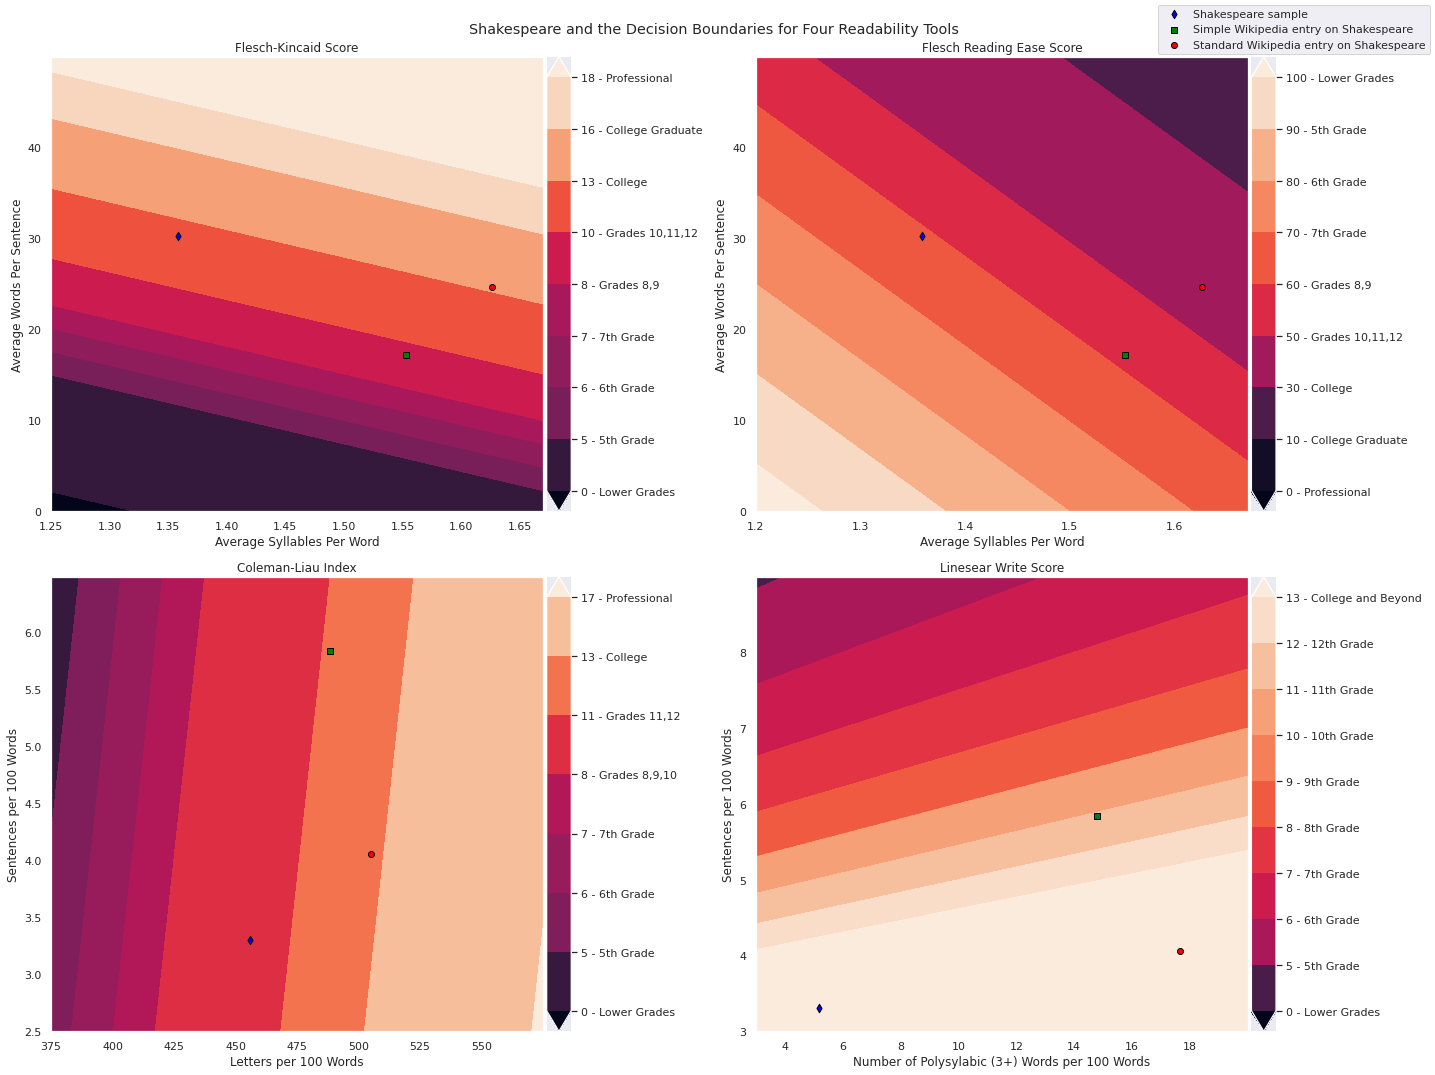

In [816]:
f, ax = subplots(nrows=2, ncols=2, figsize=(20,15))
b = np.arange(0,50,.05)
a = np.arange(1.25,1.68,.01)  
xa, yb = np.meshgrid(a,b, sparse=True)
z = 0.39 * yb + 11.8 * xa - 15.59
c = ax[0][0].contourf(a,b,z,levels=[0,5,6,7,8,10,13,16,18],extend="both")
divider = make_axes_locatable(ax[0][0])
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(c, cax=cax1, orientation='vertical');
cbar.ax.set_yticklabels(["0 - Lower Grades",
                         "5 - 5th Grade",
                         "6 - 6th Grade",
                         "7 - 7th Grade",
                         "8 - Grades 8,9",
                         "10 - Grades 10,11,12",
                         "13 - College",
                         "16 - College Graduate",
                         "18 - Professional"])
ax[0][0].set_xlabel("Average Syllables Per Word")
ax[0][0].set_ylabel("Average Words Per Sentence")
ax[0][0].set_title("Flesch-Kincaid Score");
s1 = ax[0][0].scatter(x=[r_shakespeare.statistics()['avg_syllables_per_word']],
    y=[r_shakespeare.statistics()['avg_words_per_sentence']], 
    color="blue",
    edgecolors="black", 
    marker="d", 
    label="Shakespeare sample");
s2 = ax[0][0].scatter(x=[r_simple.statistics()['avg_syllables_per_word']],
    y=[r_simple.statistics()['avg_words_per_sentence']], 
    color="green",
    edgecolors="black", 
    marker="s", 
    label="Simple Wikipedia entry on Shakespeare");
s3 = ax[0][0].scatter(x=[r_standard.statistics()['avg_syllables_per_word']],
    y=[r_standard.statistics()['avg_words_per_sentence']], 
    color="red",
    edgecolors="black", 
    marker="o", 
    label="Standard Wikipedia entry on Shakespeare");
#ax[0][0].legend();

b = np.arange(0,50,.05)
a = np.arange(1.2,1.68,.01)  
xa, yb = np.meshgrid(a,b, sparse=True)
z = -1.015 * yb - 84.6 * xa + 206.835
#z = -1*(-1.015 * yb - 84.6 * xa + 206.835) # inverted for plotting ease
c = ax[0][1].contourf(a,b,z,levels=[0,10,30,50,60,70,80,90,100],extend="both")
#c = ax[0][1].contourf(a,b,z,levels=[-100, -90, -80, -70, -60, -50, -30, -10, 0],extend="both")
divider = make_axes_locatable(ax[0][1])
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(c, cax=cax2, orientation='vertical');
cbar.ax.set_yticklabels(["0 - Professional",
                         "10 - College Graduate",
                         "30 - College",
                         "50 - Grades 10,11,12",
                         "60 - Grades 8,9",
                         "70 - 7th Grade",
                         "80 - 6th Grade",
                         "90 - 5th Grade",
                         "100 - Lower Grades",
                         ])
# cbar.ax.set_yticklabels(["100 - Lower Grades",
#                          "90 - 5th Grade",
#                          "80 - 6th Grade",
#                          "70 - 7th Grade",
#                          "60 - Grades 8,9",
#                          "50 - Grades 10,11,12",
#                          "30 - College",
#                          "10 - College Graduate",
#                          "0 - Professional",
#                          ])
ax[0][1].set_xlabel("Average Syllables Per Word")
ax[0][1].set_ylabel("Average Words Per Sentence")
ax[0][1].set_title("Flesch Reading Ease Score")
ax[0][1].scatter(x=[r_shakespeare.statistics()['avg_syllables_per_word']],
    y=[r_shakespeare.statistics()['avg_words_per_sentence']], 
    color="blue",
    edgecolors="black", 
    marker="d", 
    label="Shakespeare sample");
ax[0][1].scatter(x=[r_simple.statistics()['avg_syllables_per_word']],
    y=[r_simple.statistics()['avg_words_per_sentence']], 
    color="green",
    edgecolors="black", 
    marker="s", 
    label="Simple Wikipedia entry on Shakespeare");
ax[0][1].scatter(x=[r_standard.statistics()['avg_syllables_per_word']],
    y=[r_standard.statistics()['avg_words_per_sentence']], 
    color="red",
    edgecolors="black", 
    marker="o", 
    label="Standard Wikipedia entry on Shakespeare");

b = np.arange(2.5,6.5,.01)
a = np.arange(375,575,.01)  
xa, yb = np.meshgrid(a,b, sparse=True)
z = array([[cl(p,s)[0] for p in xa[0]] for s in yb])
c = ax[1][0].contourf(a,b,z,levels=[0,5,6,7,8,11,13,17],extend="both")
divider = make_axes_locatable(ax[1][0])
cax3 = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(c, cax=cax3, orientation='vertical');
cbar.ax.set_yticklabels(["0 - Lower Grades",
                         "5 - 5th Grade",
                         "6 - 6th Grade",
                         "7 - 7th Grade",
                         "8 - Grades 8,9,10",
                         "11 - Grades 11,12",
                         "13 - College",
                         "17 - Professional",
                         ])
ax[1][0].set_xlabel("Letters per 100 Words")
ax[1][0].set_ylabel("Sentences per 100 Words")
ax[1][0].set_title("Coleman-Liau Index")
ax[1][0].scatter(x=[100 * r_shakespeare.statistics()['num_letters'] / r_shakespeare.statistics()['num_words']],
    y=[100 * r_shakespeare.statistics()['num_sentences'] / r_shakespeare.statistics()['num_words']], 
    color="blue",
    edgecolors="black", 
    marker="d", 
    label="Shakespeare sample");
ax[1][0].scatter(x=[100 * r_simple.statistics()['num_letters'] / r_simple.statistics()['num_words']],
    y=[100 * r_simple.statistics()['num_sentences'] / r_simple.statistics()['num_words']], 
    color="green",
    edgecolors="black", 
    marker="s", 
    label="Simple Wikipedia entry on Shakespeare");
ax[1][0].scatter(x=[100 * r_standard.statistics()['num_letters'] / r_standard.statistics()['num_words']],
    y=[100 * r_standard.statistics()['num_sentences'] / r_standard.statistics()['num_words']], 
    color="red",
    edgecolors="black", 
    marker="o", 
    label="Standard Wikipedia entry on Shakespeare");

b = np.arange(3,9,.005)
a = np.arange(3,20,.005)  
xa, yb = np.meshgrid(a,b, sparse=True)
z = array([[lr(p,s)[0] for p in xa[0]] for s in yb])
c = ax[1][1].contourf(a,b,z,levels=[0,5,6,7,8,9,10,11,12,13],extend="both")
divider = make_axes_locatable(ax[1][1])
cax4 = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(c, cax=cax4, orientation='vertical');
cbar.ax.set_yticklabels(["0 - Lower Grades",
                         "5 - 5th Grade",
                         "6 - 6th Grade",
                         "7 - 7th Grade",
                         "8 - 8th Grade",
                         "9 - 9th Grade",
                         "10 - 10th Grade",
                         "11 - 11th Grade",
                         "12 - 12th Grade",
                         "13 - College and Beyond",
                         ])
ax[1][1].set_xlabel("Number of Polysylabic (3+) Words per 100 Words")
ax[1][1].set_ylabel("Sentences per 100 Words")
ax[1][1].set_title("Linesear Write Score")
ax[1][1].scatter(x=[100 * r_shakespeare.statistics()['num_polysyllabic_words'] / r_shakespeare.statistics()['num_words']],
    y=[100 * r_shakespeare.statistics()['num_sentences'] / r_shakespeare.statistics()['num_words']], 
    color="blue",
    edgecolors="black", 
    marker="d", 
    label="Shakespeare sample");
ax[1][1].scatter(x=[100 * r_simple.statistics()['num_polysyllabic_words'] / r_simple.statistics()['num_words']],
    y=[100 * r_simple.statistics()['num_sentences'] / r_simple.statistics()['num_words']], 
    color="green",
    edgecolors="black", 
    marker="s", 
    label="Simple Wikipedia entry on Shakespeare");
ax[1][1].scatter(x=[100 * r_standard.statistics()['num_polysyllabic_words'] / r_standard.statistics()['num_words']],
    y=[100 * r_standard.statistics()['num_sentences'] / r_standard.statistics()['num_words']], 
    color="red",
    edgecolors="black", 
    marker="o", 
    label="Standard Wikipedia entry on Shakespeare");
f.subplots_adjust(wspace=.6)
labels = ["Shakespeare sample", "Simple Wikipedia entry on Shakespeare", "Standard Wikipedia entry on Shakespeare"]
f.legend([s1,s2,s3], labels);
f.suptitle("Shakespeare and the Decision Boundaries for Four Readability Tools");
f.tight_layout()
f.savefig("../IMAGES/shakespeare_example.png")

## Analysis of a Sample from Wikipedia and Simplified English Wikipedia

We'll use the Wikipedia package to interact with both databases. This means that each query will be delayed. For larger experiments, it would be wise to start with a database dump instead. Since many readability tests require a minimum of 100 words to make a decision, we must drop from our sample all entries that are too short. For this reason we end up with fewer documents than requested.

The Wikipedia articles we sampled are each 100 words or more. Some are much longer. Typically Wikipedia articles front-load vital information and proceed sequentially, making the head of the articles more valuable than the tails. The tails also are more likely to include paranthetic references and other unusual writing, which bias the readability metrics. Therefore, we'll try to use the first 100 words of each article, denoted as `p100` (primary 100 words).

In [37]:
def random_pair():
    wikipedia.set_lang("simple")
    title = wikipedia.random()
    try:
        simple = wikipedia.page(title).content
        wikipedia.set_lang("en")
        standard_title = wikipedia.search(title)[0]
        standard = wikipedia.page(standard_title).content
    except:
        return (title, None, None)
    return((title, simple, standard))


def get_data(n=20000, min_length=100, max_tries=400000):
    """Collect n article pairs from simplified and normal wikipedia.
    """
    attempted_titles = []
    completed_simple_titles = []
    completed_standard_titles = []
    simple_articles = []
    standard_articles = []
    i = 0
    for i in tqdm(range(max_tries)):
        #i+=1
        if len(simple_articles) >= n:
            break
        #print(i)
        wikipedia.set_lang("simple")
        title = wikipedia.random()
        if title in attempted_titles:
            continue
        attempted_titles.append(title)
        try:
            simple = wikipedia.page(title).content
            if len(simple.split()) < min_length:
                continue
            wikipedia.set_lang("en")
            standard_title = wikipedia.search(title)[0]
            standard = wikipedia.page(standard_title).content
            simple_articles.append(simple)
            standard_articles.append(standard)
            completed_simple_titles.append(title)
            completed_standard_titles.append(standard_title)
        except:
            continue
    print("Completed!")
    return (attempted_titles, completed_simple_titles, completed_standard_titles, simple_articles, standard_articles)

In [38]:
attempted_titles, completed_simple_titles, completed_standard_titles, simple_articles, standard_articles = get_data(n=5000, min_length=100, max_tries=15000)

  0%|          | 0/15000 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/lib/python3.8/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/ubuntu/anaconda3/lib/python3.8/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Completed!


In [1144]:
print(f"We received {len(completed_simple_titles)} simple articles\
and {len(completed_standard_titles)} standard articles")

We received 4786 simple articlesand 4786 standard articles


Although these numbers may be the same and we requested matching entry pairs from the two databases (for consistency), the entries that got dropped due to length constraints may not correspond between the two datasets. This is not significant for our later work, but good to be aware of.

In [1238]:
len(completed_standard_titles)+len(completed_simple_titles)

9572

In [46]:
with open("wiki_data_backup.pkl", "wb") as outfile:
    pickle.dump((attempted_titles, completed_simple_titles, completed_standard_titles, simple_articles, standard_articles), outfile)

### Standard Readability Analysis of Wikipedia Data

We will begin by computing readability metrics for all texts in the data.

In [45]:
with open("wiki_data_backup.pkl", "rb") as infile:
    attempted_titles, completed_simple_titles, completed_standard_titles, simple_articles, standard_articles = pickle.load(infile)

In [46]:
simplified = [1] * len(simple_articles) + [0] * len(standard_articles)

In [47]:
rs_all = [Readability(t) for t in tqdm(simple_articles + standard_articles)]

  0%|          | 0/9572 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
rs_100 = [Readability(' '.join(t.split()[-100:])) for t in tqdm(simple_articles + standard_articles)]

In [ ]:
rs_p100 = [Readability(' '.join(t.split()[:100])) for t in tqdm(simple_articles + standard_articles)]

In [ ]:
with open("readability_backup.pkl", "wb") as outfile:
    pickle.dump((rs_all, rs_100, rs_p100), outfile)

The readability module we are using requires that we enumerate each of the statistics and metrics we want to preserve, which makes the next cell rather long.

In [48]:
with open("readability_backup.pkl", "rb") as infile:
    rs_all, rs_100, rs_p100 = pickle.load(infile)

In [49]:
k = len(simple_articles)
article_dictionaries = []
for i in tqdm(range(k)):
    r_simple_dict = {}
    r_standard_dict = {}
    rdicts = [r_simple_dict, r_standard_dict]
    for j in range(2):
        r_dict = rdicts[j]
        # whole article
        r = rs_all[i+j*k]
        # last 100 words
        r_100 = rs_100[i+j*k]
        # first 100
        r_p100 = rs_p100[i+j*k]
        try:
            r_dict["Text"] = (simple_articles + standard_articles)[i+j*k]
            r_dict["Text_p_100"] = ' '.join((simple_articles + standard_articles)[i+j*k].split()[:100])
            for stat in r_100.statistics():
                r_dict[stat+"_100"] = r_100.statistics()[stat]
            r_dict["Title"] = (completed_simple_titles + completed_standard_titles)[i+j*k]
            r_dict["Simplified"] = simplified[i+j*k]
            r_dict["Dale-Chall Score 100"] = r_100.dale_chall().score 
            r_dict["Dale-Chall Grade 100"] = r_100.dale_chall().grade_levels 
            r_dict["ARI Score 100"] = r_100.ari().score 
            r_dict["ARI Grade 100"] = r_100.ari().grade_levels 
            r_dict["Coleman-Liau Score 100"] = r_100.coleman_liau().score 
            r_dict["Coleman-Liau Grade 100"] = r_100.coleman_liau().grade_level 
            r_dict["Spache Score 100"] = r_100.spache().score 
            r_dict["Spache Grade 100"] = r_100.spache().grade_level 
            r_dict["Linsear Write Score 100"] = r_100.linsear_write().score 
            r_dict["Linsear Write Grade 100"] = r_100.linsear_write().grade_level 
            r_dict["Flesch Score 100"] = r_100.flesch().score 
            r_dict["Flesch Grade 100"] = r_100.flesch().grade_levels
            r_dict["Flesch-Kincaid Score 100"] = r_100.flesch_kincaid().score
            r_dict["Flesch-Kincaid Grade 100"] = r_100.flesch_kincaid().grade_level
        except:
            r_dict["Dale-Chall Score 100"] = None 
            r_dict["Dale-Chall Grade 100"] = None
            r_dict["ARI Score 100"] = None
            r_dict["ARI Grade 100"] = None 
            r_dict["Coleman-Liau Score 100"] = None
            r_dict["Coleman-Liau Grade 100"] = None
            r_dict["Spache Score 100"] = None
            r_dict["Spache Grade 100"] = None
            r_dict["Linsear Write Score 100"] = None
            r_dict["Linsear Write Grade 100"] = None
            r_dict["Flesch Score 100"] = None
            r_dict["Flesch Grade 100"] = None
            r_dict["Flesch-Kincaid Score 100"] = None
            r_dict["Flesch-Kincaid Grade 100"] = None
        try:
            r_dict["Text"] = (simple_articles + standard_articles)[i+j*k]
            for stat in r_100.statistics():
                r_dict[stat+"_p100"] = r_p100.statistics()[stat]
            r_dict["Dale-Chall Score p100"] = r_p100.dale_chall().score 
            r_dict["Dale-Chall Grade p100"] = r_p100.dale_chall().grade_levels 
            r_dict["ARI Score p100"] = r_p100.ari().score 
            r_dict["ARI Grade p100"] = r_p100.ari().grade_levels 
            r_dict["Coleman-Liau Score p100"] = r_p100.coleman_liau().score 
            r_dict["Coleman-Liau Grade p100"] = r_p100.coleman_liau().grade_level 
            r_dict["Spache Score p100"] = r_p100.spache().score 
            r_dict["Spache Grade p100"] = r_p100.spache().grade_level 
            r_dict["Linsear Write Score p100"] = r_p100.linsear_write().score 
            r_dict["Linsear Write Grade p100"] = r_p100.linsear_write().grade_level 
            r_dict["Flesch Score p100"] = r_p100.flesch().score 
            r_dict["Flesch Grade p100"] = r_p100.flesch().grade_levels
            r_dict["Flesch-Kincaid Score p100"] = r_p100.flesch_kincaid().score
            r_dict["Flesch-Kincaid Grade p100"] = r_p100.flesch_kincaid().grade_level
        except:
            r_dict["Dale-Chall Score p100"] = None 
            r_dict["Dale-Chall Grade p100"] = None
            r_dict["ARI Score p100"] = None
            r_dict["ARI Grade p100"] = None 
            r_dict["Coleman-Liau Score p100"] = None
            r_dict["Coleman-Liau Grade p100"] = None
            r_dict["Spache Score p100"] = None
            r_dict["Spache Grade p100"] = None
            r_dict["Linsear Write Score p100"] = None
            r_dict["Linsear Write Grade p100"] = None
            r_dict["Flesch Score p100"] = None
            r_dict["Flesch Grade p100"] = None
            r_dict["Flesch-Kincaid Score p100"] = None
            r_dict["Flesch-Kincaid Grade p100"] = None
        try:
            for stat in r.statistics():
                r_dict[stat] = r.statistics()[stat]
            r_dict["Dale-Chall Score"] = r.dale_chall().score 
            r_dict["Dale-Chall Grade"] = r.dale_chall().grade_levels 
            r_dict["ARI Score"] = r.ari().score 
            r_dict["ARI Grade"] = r.ari().grade_levels 
            r_dict["Coleman-Liau Score"] = r.coleman_liau().score 
            r_dict["Coleman-Liau Grade"] = r.coleman_liau().grade_level 
            r_dict["Spache Score"] = r.spache().score 
            r_dict["Spache Grade"] = r.spache().grade_level 
            r_dict["Linsear Write Score"] = r.linsear_write().score 
            r_dict["Linsear Write Grade"] = r.linsear_write().grade_level 
            r_dict["Flesch Score"] = r.flesch().score 
            r_dict["Flesch Grade"] = r.flesch().grade_levels
            r_dict["Flesch-Kincaid Score"] = r.flesch_kincaid().score
            r_dict["Flesch-Kincaid Grade"] = r.flesch_kincaid().grade_level
        except:
            r_dict["Dale-Chall Score"] = None 
            r_dict["Dale-Chall Grade"] = None
            r_dict["ARI Score"] = None
            r_dict["ARI Grade"] = None 
            r_dict["Coleman-Liau Score"] = None
            r_dict["Coleman-Liau Grade"] = None
            r_dict["Spache Score"] = None
            r_dict["Spache Grade"] = None
            r_dict["Linsear Write Score"] = None
            r_dict["Linsear Write Grade"] = None
            r_dict["Flesch Score"] = None
            r_dict["Flesch Grade"] = None
            r_dict["Flesch-Kincaid Score"] = None
            r_dict["Flesch-Kincaid Grade"] = None
    if not None in list(r_simple_dict.values()):
        article_dictionaries.append(r_simple_dict)
    if not None in list(r_standard_dict.values()):
        article_dictionaries.append(r_standard_dict)

  0%|          | 0/4786 [00:00<?, ?it/s]

In [59]:
df = pd.DataFrame.from_records(article_dictionaries)

## Transition diagram

## Compute Extra Text Features

Here we'll include some customized features not already unearthed by the readability package. Flesch and other researchers from the beginning of readability research have noted the predictive value of parts of speech statistics, but these were hard to count by hand, so they don't appear in the standard formulae. We'll compute and use them with the goal of separating the simplified and standard articles.

Depending on whether you have used `nltk` tagging before, you may need to download data like the next cell shows. Fortunately `nltk` error messages are comprehensive and will tell you what you are missing.

In [41]:
# nltk.download('tagsets')

In [61]:
tagdict = load('help/tagsets/upenn_tagset.pickle')
pos_keys = list(tagdict.keys())
pos_keys.append("#")

If you want to know what the parts of speech (pos) tags mean, the `tagdict` can decode them.

In [62]:
tagdict["."]

('sentence terminator', '. ! ? ')

In [63]:
pos_dicts = []
for text in tqdm(df.Text_p_100.to_numpy()):
    d = {pos_key:0 for pos_key in pos_keys}
    tokens = nltk.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    used_keys = array([i[1] for i in pos])
    for tag in pos:
        d[tag[1]] += 1
    pos_dicts.append(d)
pos_df = pd.DataFrame.from_records(pos_dicts)

  0%|          | 0/2459 [00:00<?, ?it/s]

For the purpose of predicting simple vs. standard labels, there is no reason to keep any of the pos features that were not seen in this corpus.

In [64]:
nan_value = float("NaN")
pos_df.replace(0, nan_value, inplace=True)
pos_df.dropna(how='all', axis=1, inplace=True)
pos_df.replace(nan_value, 0, inplace=True)
#pos_df

In [65]:
df = pd.concat([df, pos_df], axis=1)

### Visualizing the Empirical Distributions of Readability Statistics

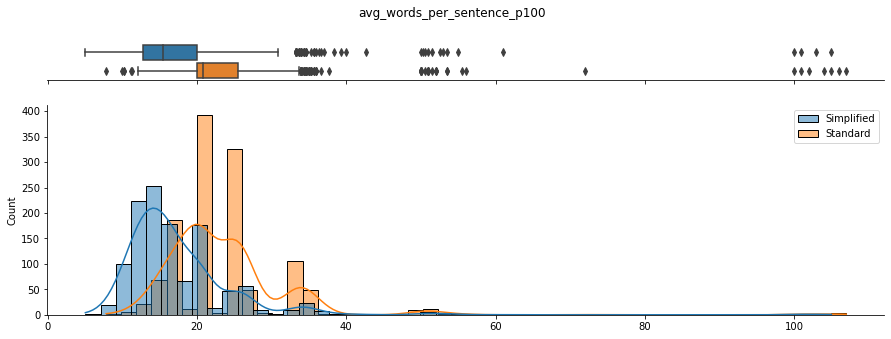

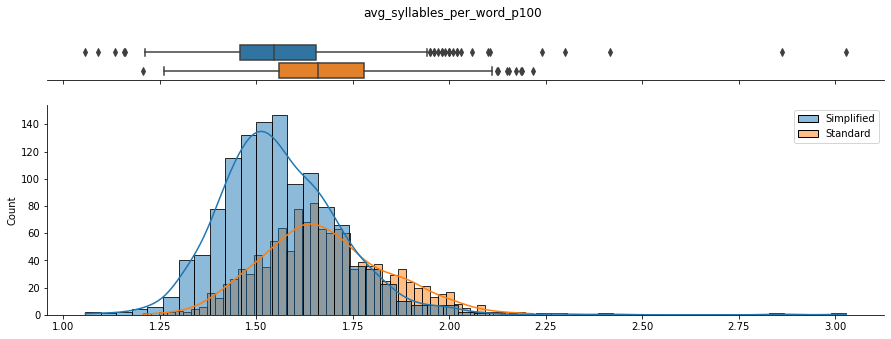

In [66]:
scores = [i for i in df.columns if ("avg" in i) and ("p100" in i)]
nbins = int(sqrt(len(df)))
for score in scores:
    # Some silly pandas nonsense occurs here. Seaborn wants a dataframe
    # object, but the two datasets are in no way parallel and may have
    # different lengths.
    plotdf1 = pd.DataFrame()
    plotdf2 = pd.DataFrame()
    plotdf1["Simplified"] = df[df["Simplified"]==1][score].to_numpy()
    plotdf2["Standard"] = df[df["Simplified"]==0][score].to_numpy()
    plotdf = pd.concat([plotdf1, plotdf2], axis=1) 
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)},
                                        figsize=(15,5),
                                       )
    sns.boxplot(data=plotdf, ax=ax_box,orient="h")
    sns.histplot(data=plotdf, ax=ax_hist, kde=True, multiple="dodge", common_bins=False, bins=nbins)
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    f.suptitle(score);

In [67]:
# scores = [i for i in df.columns if "_100" in i]
# nbins = int(sqrt(len(df)))
# for score in scores:
#     # Some silly pandas nonsense occurs here. Seaborn wants a dataframe
#     # object, but the two datasets are in no way parallel and may have
#     # different lengths.
#     plotdf1 = pd.DataFrame()
#     plotdf2 = pd.DataFrame()
#     plotdf1["Simplified"] = df[df["Simplified"]==1][score].to_numpy()
#     plotdf2["Standard"] = df[df["Simplified"]==0][score].to_numpy()
#     plotdf = pd.concat([plotdf1, plotdf2], axis=1) 
#     f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
#                                         gridspec_kw={"height_ratios": (.15, .85)},
#                                         figsize=(15,5),
#                                        )
#     sns.boxplot(data=plotdf, ax=ax_box,orient="h")
#     sns.histplot(data=plotdf, ax=ax_hist, kde=True, multiple="dodge", common_bins=False, bins=nbins)
#     ax_box.set(yticks=[])
#     sns.despine(ax=ax_hist)
#     sns.despine(ax=ax_box, left=True)
#     f.suptitle(score);

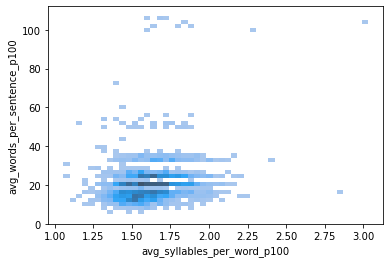

In [68]:
sns.histplot(data=df, x="avg_syllables_per_word_p100", y='avg_words_per_sentence_p100', kde=True, multiple="dodge", common_bins=False, bins=nbins);

### Flesch-Kincaid Data 

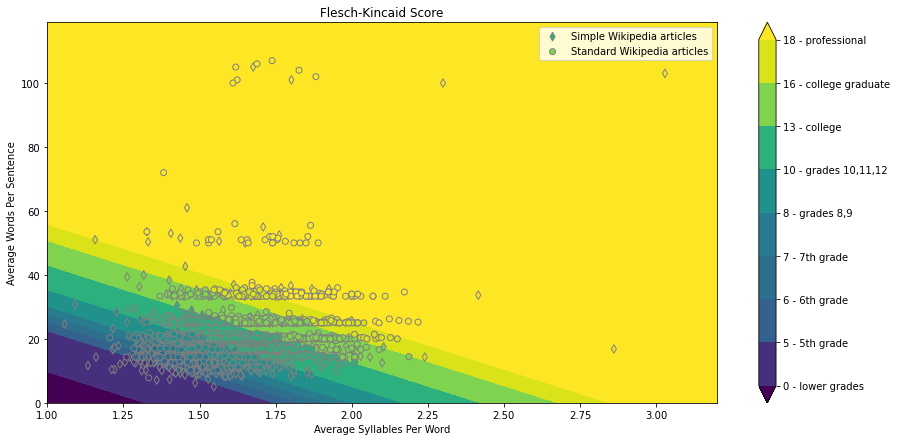

In [69]:
b = np.arange(0,120,1)
a = np.arange(1,3.25,.1)  
xa, yb = np.meshgrid(a,b, sparse=True)
z = 0.39 * yb + 11.8 * xa - 15.59
f = figure(figsize(15,7))
c = plt.contourf(a,b,z,levels=[0,5,6,7,8,10,13,16,18],extend="both")
cbar = colorbar();
cbar.ax.set_yticklabels(["0 - lower grades",
                         "5 - 5th grade",
                         "6 - 6th grade",
                         "7 - 7th grade",
                         "8 - grades 8,9",
                         "10 - grades 10,11,12",
                         "13 - college",
                         "16 - college graduate",
                         "18 - professional"])
xlabel("Average Syllables Per Word")
ylabel("Average Words Per Sentence")
title("Flesch-Kincaid Score")
color=df["Flesch-Kincaid Score p100"]
# sicolors = c.to_rgba(df[df["Simplified"]==1]['Flesch-Kincaid Score p100'])
# stcolors = c.to_rgba(df[df["Simplified"]==0]['Flesch-Kincaid Score p100'])
sidf = df[df["Simplified"]==1].copy()
stdf = df[df["Simplified"]==0].copy()
sicolors = level_color_points(sidf['Flesch-Kincaid Score p100'], c.levels, c.tcolors)
stcolors = level_color_points(stdf['Flesch-Kincaid Score p100'], c.levels, c.tcolors)
scatter(sidf["avg_syllables_per_word_p100"], 
        sidf['avg_words_per_sentence_p100'], 
        c=sicolors,
        edgecolors="gray", 
        marker="d", 
        label="Simple Wikipedia articles");
scatter(stdf["avg_syllables_per_word_p100"], 
        stdf['avg_words_per_sentence_p100'], 
        c=stcolors,
        edgecolors="gray", 
        marker="o", 
        label="Standard Wikipedia articles");
legend();

### Flesch Reading Ease Score Data

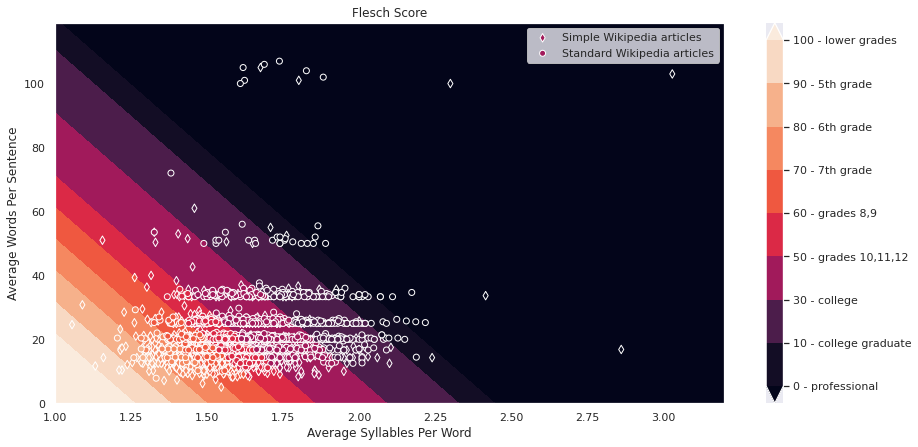

In [711]:
b = np.arange(0,120,1)
a = np.arange(1,3.25,.1)  
xa, yb = np.meshgrid(a,b, sparse=True)
z = -1.015 * yb - 84.6 * xa + 206.835
f = figure(figsize(15,7))
c = plt.contourf(a,b,z,levels=[0,10,30,50,60,70,80,90,100],extend="both")
cbar = colorbar();
cbar.ax.set_yticklabels(["0 - professional",
                         "10 - college graduate",
                         "30 - college",
                         "50 - grades 10,11,12",
                         "60 - grades 8,9",
                         "70 - 7th grade",
                         "80 - 6th grade",
                         "90 - 5th grade",
                         "100 - lower grades",
                         ])
xlabel("Average Syllables Per Word")
ylabel("Average Words Per Sentence")
title("Flesch Score")
sidf = df[df["Simplified"]==1].copy()
stdf = df[df["Simplified"]==0].copy()
sicolors = level_color_points(sidf['Flesch Score p100'], c.levels, c.tcolors)
stcolors = level_color_points(stdf['Flesch Score p100'], c.levels, c.tcolors)
scatter(sidf["avg_syllables_per_word_p100"], 
        sidf['avg_words_per_sentence_p100'], 
        c=sicolors,
        edgecolors="white", 
        marker="d", 
        label="Simple Wikipedia articles");
scatter(stdf["avg_syllables_per_word_p100"], 
        stdf['avg_words_per_sentence_p100'], 
        c=stcolors,
        edgecolors="white", 
        marker="o", 
        label="Standard Wikipedia articles");
legend();

## Coleman-Liau Index Data

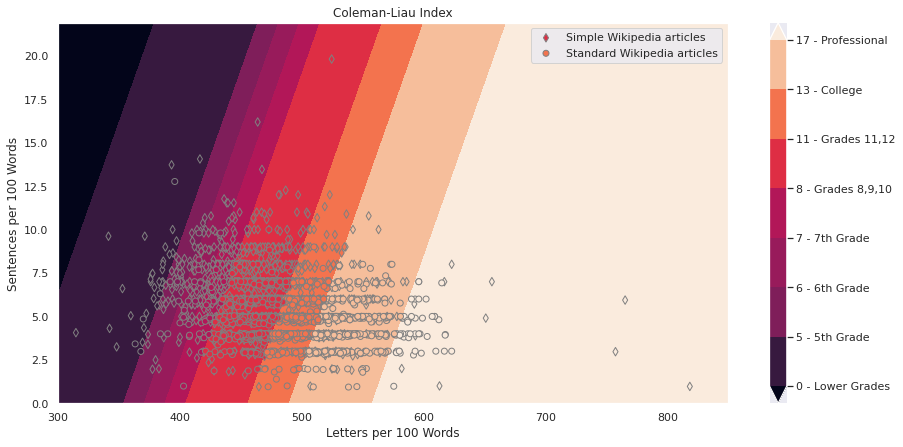

In [691]:
b = np.arange(0,22,.1)
a = np.arange(300,850,.5)  
xa, yb = np.meshgrid(a,b, sparse=True)
#xa, yb = np.meshgrid(a,b, sparse=True, copy=False)
z = array([[cl(p,s)[0] for p in xa[0]] for s in yb])
#z = 0.0588 * xa - 0.296 * yb -15.8
f, ax = subplots(nrows=1, ncols=1, figsize=(15,7))
c = ax.contourf(a,b,z,levels=[0,5,6,7,8,11,13,17],extend="both")
cbar = colorbar(c, ax=ax);
cbar.ax.set_yticklabels(["0 - Lower Grades",
                         "5 - 5th Grade",
                         "6 - 6th Grade",
                         "7 - 7th Grade",
                         "8 - Grades 8,9,10",
                         "11 - Grades 11,12",
                         "13 - College",
                         "17 - Professional",
                         ])
xlabel("Letters per 100 Words")
ylabel("Sentences per 100 Words")
title("Coleman-Liau Index")
sidf = df[df["Simplified"]==1].copy()
stdf = df[df["Simplified"]==0].copy()
stdf["num_letters_out_of_100_p100"] = 100*stdf["num_letters_p100"]/stdf["num_words_p100"]
stdf["num_sentences_out_of_100_p100"] = 100*stdf['num_sentences_p100']/stdf["num_words_p100"]
sidf["num_letters_out_of_100_p100"] = 100*sidf["num_letters_p100"]/sidf["num_words_p100"]
sidf["num_sentences_out_of_100_p100"] = 100*sidf['num_sentences_p100']/sidf["num_words_p100"]
sicolors = level_color_points(sidf['Coleman-Liau Score p100'], c.levels, c.tcolors)
stcolors = level_color_points(stdf['Coleman-Liau Score p100'], c.levels, c.tcolors)
ax.scatter(sidf["num_letters_out_of_100_p100"], 
        sidf["num_sentences_out_of_100_p100"], 
        c=sicolors,
        edgecolors="gray", 
        marker="d", 
        label="Simple Wikipedia articles");
ax.scatter(stdf["num_letters_out_of_100_p100"], 
        stdf["num_sentences_out_of_100_p100"],
        c=stcolors,
        edgecolors="gray", 
        marker="o", 
        label="Standard Wikipedia articles");
ax.legend();

## Linear Write Score Data

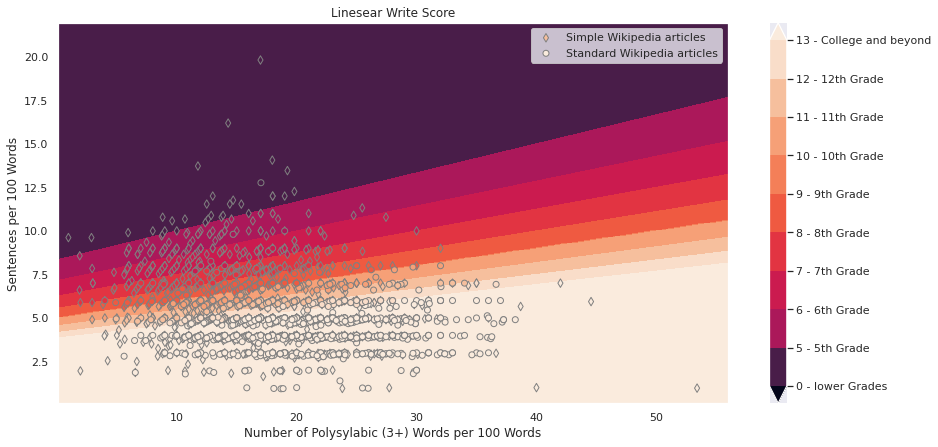

In [687]:
b = np.arange(.1,22,.05)
a = np.arange(.1,56,.05)  
xa, yb = np.meshgrid(a,b, sparse=True)
z = array([[lr(p,s)[0] for p in xa[0]] for s in yb])
f = figure(figsize(15,7))
c = plt.contourf(a,b,z,levels=[0,5,6,7,8,9,10,11,12,13],extend="both")
cbar = colorbar();
cbar.ax.set_yticklabels(["0 - lower Grades",
                         "5 - 5th Grade",
                         "6 - 6th Grade",
                         "7 - 7th Grade",
                         "8 - 8th Grade",
                         "9 - 9th Grade",
                         "10 - 10th Grade",
                         "11 - 11th Grade",
                         "12 - 12th Grade",
                         "13 - College and beyond",
                         ])
xlabel("Number of Polysylabic (3+) Words per 100 Words")
ylabel("Sentences per 100 Words")
title("Linesear Write Score")
sidf = df[df["Simplified"]==1].copy()
stdf = df[df["Simplified"]==0].copy()
stdf["num_polysyllabic_out_of_100_p100"] = 100*stdf["num_polysyllabic_words_p100"]/stdf["num_words_p100"]
stdf["num_sentences_out_of_100_p100"] = 100*stdf['num_sentences_p100']/stdf["num_words_p100"]
sicolors = level_color_points(sidf['Linsear Write Score p100'], c.levels, c.tcolors)
stcolors = level_color_points(stdf['Linsear Write Score p100'], c.levels, c.tcolors)
scatter(100*sidf["num_polysyllabic_words_p100"]/sidf["num_words_p100"], 
        100*sidf['num_sentences_p100']/sidf["num_words_p100"], 
        c=sicolors,
        edgecolors="gray", 
        marker="d", 
        label="Simple Wikipedia articles");
scatter(100*stdf["num_polysyllabic_words_p100"]/stdf["num_words_p100"], 
        100*stdf['num_sentences_p100']/stdf["num_words_p100"],
        c=stcolors,
        edgecolors="gray", 
        marker="o", 
        label="Standard Wikipedia articles");
legend();

### Visualizing the Empirical Distributions of Readability Metric Values

In [70]:
scores = [i for i in df.columns if i[-10:]=="Score p100"]
scores

['Dale-Chall Score p100',
 'ARI Score p100',
 'Coleman-Liau Score p100',
 'Spache Score p100',
 'Linsear Write Score p100',
 'Flesch Score p100',
 'Flesch-Kincaid Score p100']

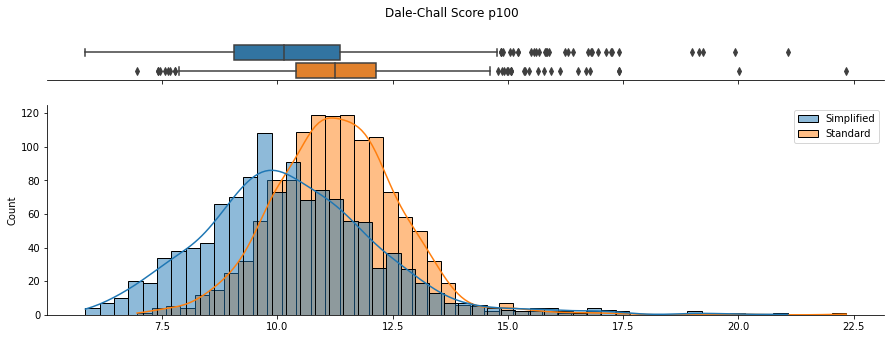

In [73]:

nbins = int(sqrt(len(df)))
for score in ['Dale-Chall Score p100']:
    # Some silly pandas nonsense occurs here. Seaborn wants a dataframe
    # object, but the two datasets are in no way parallel and may have
    # different lengths.
    plotdf1 = pd.DataFrame()
    plotdf2 = pd.DataFrame()
    plotdf1["Simplified"] = df[df["Simplified"]==1][score].to_numpy()
    plotdf2["Standard"] = df[df["Simplified"]==0][score].to_numpy()
    plotdf = pd.concat([plotdf1, plotdf2], axis=1) 
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)},
                                        figsize=(15,5),
                                       )
    sns.boxplot(data=plotdf, ax=ax_box,orient="h")
    sns.histplot(data=plotdf, ax=ax_hist, kde=True, multiple="dodge", common_bins=False, bins=nbins)
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    f.suptitle(score);
    f.savefig("../IMAGES/Figure_2_Wikipedia_Dale_Chall.png")

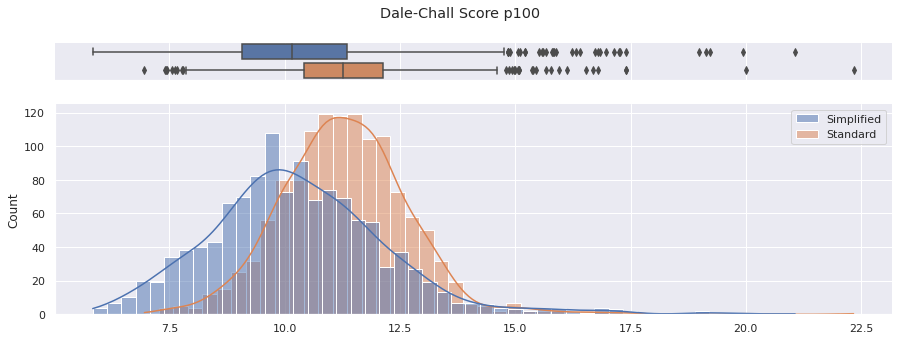

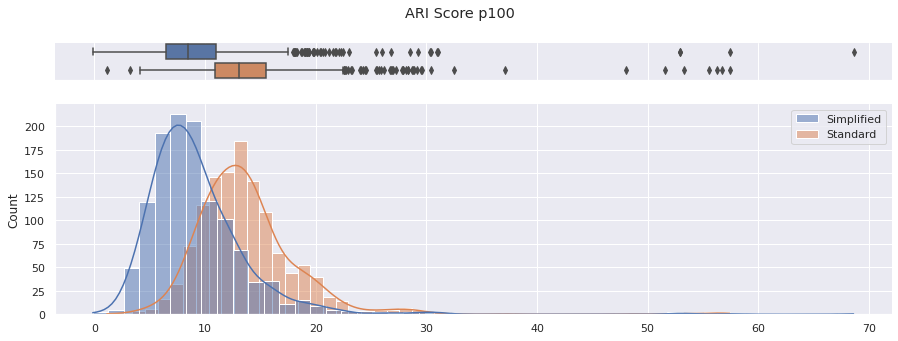

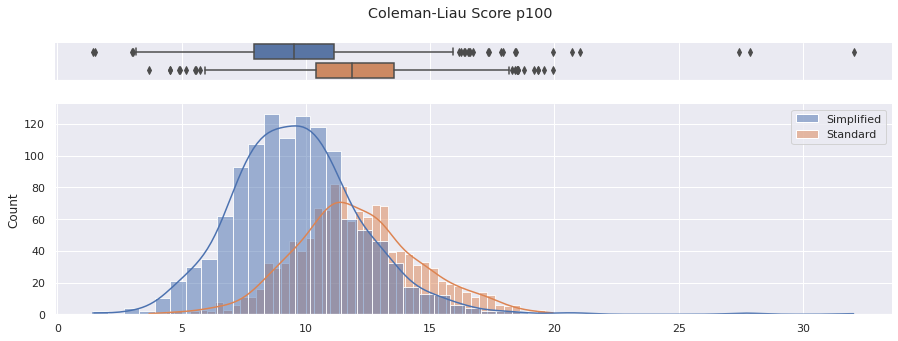

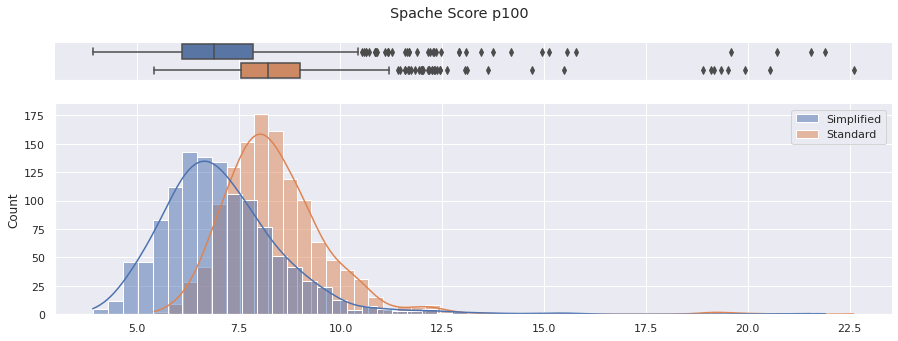

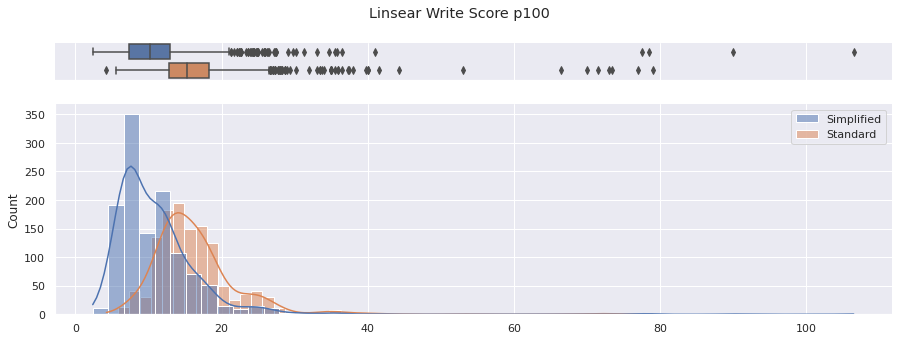

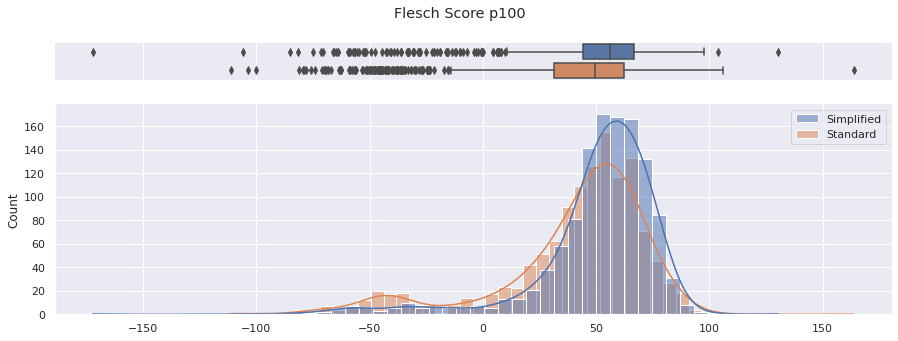

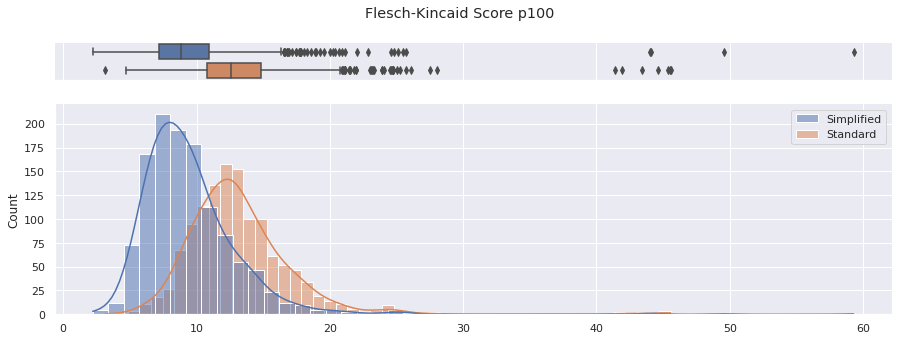

In [402]:
scores = [i for i in df.columns if i[-10:]=="Score p100"]
nbins = int(sqrt(len(df)))
for score in scores:
    # Some silly pandas nonsense occurs here. Seaborn wants a dataframe
    # object, but the two datasets are in no way parallel and may have
    # different lengths.
    plotdf1 = pd.DataFrame()
    plotdf2 = pd.DataFrame()
    plotdf1["Simplified"] = df[df["Simplified"]==1][score].to_numpy()
    plotdf2["Standard"] = df[df["Simplified"]==0][score].to_numpy()
    plotdf = pd.concat([plotdf1, plotdf2], axis=1) 
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)},
                                        figsize=(15,5),
                                       )
    sns.boxplot(data=plotdf, ax=ax_box,orient="h")
    sns.histplot(data=plotdf, ax=ax_hist, kde=True, multiple="dodge", common_bins=False, bins=nbins)
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    f.suptitle(score);

In [1147]:
# scores = [i for i in df.columns if i[-9:]=="Score 100"]
# nbins = int(sqrt(len(df)))
# for score in scores:
#     # Some silly pandas nonsense occurs here. Seaborn wants a dataframe
#     # object, but the two datasets are in no way parallel and may have
#     # different lengths.
#     plotdf1 = pd.DataFrame()
#     plotdf2 = pd.DataFrame()
#     plotdf1["Simplified"] = df[df["Simplified"]==1][score].to_numpy()
#     plotdf2["Standard"] = df[df["Simplified"]==0][score].to_numpy()
#     plotdf = pd.concat([plotdf1, plotdf2], axis=1) 
#     f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
#                                         gridspec_kw={"height_ratios": (.15, .85)},
#                                         figsize=(15,5),
#                                        )
#     sns.boxplot(data=plotdf, ax=ax_box,orient="h")
#     sns.histplot(data=plotdf, ax=ax_hist, kde=True, multiple="dodge", common_bins=False, bins=nbins)
#     ax_box.set(yticks=[])
#     sns.despine(ax=ax_hist)
#     sns.despine(ax=ax_box, left=True)
#     f.suptitle(score);

In [1148]:
# scores = [i for i in df.columns if i[-5:]=="Score"]
# nbins = int(sqrt(len(df)))
# for score in scores:
#     # Some silly pandas nonsense occurs here. Seaborn wants a dataframe
#     # object, but the two datasets are in no way parallel and may have
#     # different lengths.
#     plotdf1 = pd.DataFrame()
#     plotdf2 = pd.DataFrame()
#     plotdf1["Simplified"] = df[df["Simplified"]==1][score].to_numpy()
#     plotdf2["Standard"] = df[df["Simplified"]==0][score].to_numpy()
#     plotdf = pd.concat([plotdf1, plotdf2], axis=1) 
#     f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
#                                         gridspec_kw={"height_ratios": (.15, .85)},
#                                         figsize=(15,5),
#                                        )
#     sns.boxplot(data=plotdf, ax=ax_box,orient="h")
#     sns.histplot(data=plotdf, ax=ax_hist, kde=True, multiple="dodge", common_bins=False, bins=nbins)
#     ax_box.set(yticks=[])
#     sns.despine(ax=ax_hist)
#     sns.despine(ax=ax_box, left=True)
#     f.suptitle(score);

### Examples of Extreme Behavior in Text Tails

In [389]:
df.loc[df[df["Simplified"]==1]["avg_words_per_sentence_100"].idxmax()]

Text                          Fotbal Club Rapid București is a Romanian asso...
num_letters_100                                                             599
num_words_100                                                               189
num_sentences_100                                                             1
num_polysyllabic_words_100                                                   12
avg_words_per_sentence_100                                                189.0
avg_syllables_per_word_100                                             0.941799
Title                                                        FC Rapid București
Simplified                                                                    1
Dale-Chall Score 100                                                  27.547725
Dale-Chall Grade 100                                         [college_graduate]
ARI Score 100                                                          87.99746
ARI Grade 100                           

In [391]:
" ".join((df[df["Simplified"]==1]).loc[df[df["Simplified"]==1]["avg_words_per_sentence_100"].idxmax()].Text.split()[-100:])

'Honours == Liga I Winners (3): 1966–67, 1998–99, 2002–03 Runners-up (14): 1936–37, 1937–38, 1939–40, 1940–41, 1948–49, 1950, 1963–64, 1964–65, 1965–66, 1969–70, 1970–71, 1997–98, 1999–00, 2005–06Liga II Winners (6): 1952, 1955, 1974–75, 1982–83, 1989–90, 2015–16 Runners-up (3): 1979–80, 1981–82, 2013–14Cupa Eroilor (Heroes Cup) Winners (1): 1942Cupa României Winners (13): 1934–35, 1936–37, 1937–38, 1938–39, 1939–40, 1940–41, 1941–42, 1971–72, 1974–75, 1997–98, 2001–02, 2005–06, 2006–07 Runners-up (6): 1960–61, 1961–62, 1967–68, 1994–95, 1998–99, 2011–12Supercupa României Winners (4): 1999, 2002, 2003, 2007 Runners-up (2): 1998, 2006 == References == == Other websites == Official website of the club Archived 2008-12-17 at the Wayback Machine (in Romanian)'

In [392]:
" ".join((df[df["Simplified"]==1]).loc[df[df["Simplified"]==1]["avg_words_per_sentence_100"].idxmin()].Text.split()[-100:])

'Bremer, Kåre. (1994). Asteraceae: Cladistics & Classification. Portland, OR: Timber Press. ISBN 0-88192-275-7. Cassini, Alexandre de (1794–1823). "unknown". Journal de Physique, de Chimie et d\'Histoire Naturelle. Paris. 88: 196. J. Phys. Chim. Hist. Nat. Arts. Retrieved 2008-06-30. CS1 maint: date format (link) Robinson, Harold Ernest. (1981). A Revision of the Tribal and Subtribal Limits of the Heliantheae (Asteraceae). Smithsonian Contributions to Botany: 51. Strother, John L. (1991). Taxonomy of Complaya, Elaphandra, Iogeton, Jefea, Wamalchitamia, Wedelia, Zexmenia, and Zyzyxia (Compositae - Heliantheae - Ecliptinae). Systematic Botany Monographs: 33. ISBN 0-912861-33-9. == Other websites == Media related to Heliantheae at Wikimedia Commons'

In [215]:
df.loc[df[df["Simplified"]==1]["Flesch Score 100"].idxmin()]

Text                          See Mammals for more info\nClass: Mammalia: \n...
num_letters_100                                                             872
num_words_100                                                               108
num_sentences_100                                                             1
num_polysyllabic_words_100                                                   61
avg_words_per_sentence_100                                                108.0
avg_syllables_per_word_100                                             3.185185
Title                                                       Mammalia (taxonomy)
Simplified                                                                    1
Dale-Chall Score 100                                                  20.689596
Dale-Chall Grade 100                                         [college_graduate]
ARI Score 100                                                         70.598889
ARI Grade 100                           

In [216]:
" ".join(df.loc[df[df["Simplified"]==1]["Flesch Score 100"].idxmin()].Text.split()[-100:])

'Order: Didelphimorphia Order: Paucituberculata Superorder: Australodelphia Order: Microbiotheria Order: Dasyuromorphia Order: Peramelemorphia Order: Notoryctemorphia Order: Diprotodontia Cohort: Eutheria Superorder: Xenarthra Order: Pilosa Order: Cingulata Superorder: Leptictida (extinct) Superorder: Anagalida Mirordo: Macroscelidea Order: Rodentia Order: Lagomorpha Superorder: Archonta Suborder: Dermoptera Order: Primates Order: Scandentia Order: Chiroptera Superorder: Lipotyphla Order: Chrysochloridea Order: Erinaceomorpha Order: Soricomorpha Superorder: Ferae Order: Carnivora Order: Cimolesta Superorder: Ungulata Order: Tubulidentata Order: Uranotheria Suborder: Hyracoidea suborder: Proboscidea Suborder: †Desmostylia (extinct) Infraordo: Sirenia Suborder: †Embrythopoda (extinct) Order: Artiodactyla Suborder: Cetacea Order: Perissodactyla Superorder †Meridiungulata Order: †Notoungulata (extinct) Order: †Astrapotheria (extinct) Order: †Xenungulata (extinct) Order: †Litopterna (extinc

In [217]:
df.loc[df[df["Simplified"]==1]["Flesch Score 100"].idxmin()]["Flesch Grade 100"]

['college_graduate']

In [218]:
" ".join(df.loc[df[df["Simplified"]==1]["Flesch-Kincaid Score 100"].idxmax()].Text.split()[-100:])

'Honours == Liga I Winners (3): 1966–67, 1998–99, 2002–03 Runners-up (14): 1936–37, 1937–38, 1939–40, 1940–41, 1948–49, 1950, 1963–64, 1964–65, 1965–66, 1969–70, 1970–71, 1997–98, 1999–00, 2005–06Liga II Winners (6): 1952, 1955, 1974–75, 1982–83, 1989–90, 2015–16 Runners-up (3): 1979–80, 1981–82, 2013–14Cupa Eroilor (Heroes Cup) Winners (1): 1942Cupa României Winners (13): 1934–35, 1936–37, 1937–38, 1938–39, 1939–40, 1940–41, 1941–42, 1971–72, 1974–75, 1997–98, 2001–02, 2005–06, 2006–07 Runners-up (6): 1960–61, 1961–62, 1967–68, 1994–95, 1998–99, 2011–12Supercupa României Winners (4): 1999, 2002, 2003, 2007 Runners-up (2): 1998, 2006 == References == == Other websites == Official website of the club Archived 2008-12-17 at the Wayback Machine (in Romanian)'

In [219]:
df.loc[df[df["Simplified"]==1]["Flesch-Kincaid Score 100"].idxmax()]["Flesch-Kincaid Grade 100"]

'67'

In [220]:
" ".join(df.loc[df[df["Simplified"]==1]["Flesch Score 100"].idxmax()].Text.split()[-100:])

'was also celebrated in Austria, Israel and Ukraine. == Literature == Александра Милованова (2019-11-11). "День Пианиста 8 ноября - истоки праздника". Миасский рабочий (in Russian). Retrieved 2020-12-27. Андрей Семенов (2020-02-04). "8 ноября — Всемирный день пианиста". Новые Ведомости (in Russian). Retrieved 2020-12-27. == References == == Other websites == "В Минске отметят День пианиста". interfax.by (in Russian). 2019-10-29. Retrieved 2020-12-27. "День Пианиста 8 ноября. История праздника". yk.kz (in Russian). 2020-03-15. Retrieved 2020-12-27. "Международный день пианиста отмечают 8 ноября". ГТРК «Нижний Новгород» (in Russian). 2019-11-08. Retrieved 2020-12-27. "День пианиста в Минске отметили музыкальным флешмобом". Мир 24 (in Russian). 2019-11-09. Retrieved 2020-12-27.'

In [221]:
df.loc[df[df["Simplified"]==1]["Flesch Score 100"].idxmax()]["Flesch Grade 100"]

['college_graduate']

In [222]:
" ".join(df.loc[df[df["Simplified"]==1]["Flesch-Kincaid Score 100"].idxmin()].Text.split()[-100:])

'was also celebrated in Austria, Israel and Ukraine. == Literature == Александра Милованова (2019-11-11). "День Пианиста 8 ноября - истоки праздника". Миасский рабочий (in Russian). Retrieved 2020-12-27. Андрей Семенов (2020-02-04). "8 ноября — Всемирный день пианиста". Новые Ведомости (in Russian). Retrieved 2020-12-27. == References == == Other websites == "В Минске отметят День пианиста". interfax.by (in Russian). 2019-10-29. Retrieved 2020-12-27. "День Пианиста 8 ноября. История праздника". yk.kz (in Russian). 2020-03-15. Retrieved 2020-12-27. "Международный день пианиста отмечают 8 ноября". ГТРК «Нижний Новгород» (in Russian). 2019-11-08. Retrieved 2020-12-27. "День пианиста в Минске отметили музыкальным флешмобом". Мир 24 (in Russian). 2019-11-09. Retrieved 2020-12-27.'

In [223]:
df.loc[df[df["Simplified"]==1]["Flesch-Kincaid Score 100"].idxmin()]["Flesch-Kincaid Grade 100"]

'-4'

In [224]:
" ".join(df.loc[df[df["Simplified"]==0]["Flesch-Kincaid Score 100"].idxmax()].Text.split()[-100:])

'=== Czech First League records === Best position: 1st (see Honours) Worst position: 5th (2005–06, 2017–18) Biggest home win: Sparta 7–0 České Budějovice (1999–2000) Biggest away win: Žižkov 1–6 Sparta (1998–99), Hradec Králové 0–5 Sparta (2001–02), Most 0–5 Sparta (2007–08), Brno 0–5 Sparta (2010–11) Biggest home defeat: Sparta 0–3 Jablonec (2006–07), Sparta 1–4 Slavia (2008–09), Sparta 0–3 Liberec (2011–12), Sparta 0–3 Mladá Boleslav (2011–12), Sparta 0–3 Plzeň (2015–16), Sparta 0–3 Slavia (2019–20) Biggest away defeat: Plzeň 4–0 Sparta (2018–19), Slovácko 4–0 Sparta (2021–22) == Notes == == References == == External links == Official website AC Sparta Prague at UEFA'

In [225]:
df.loc[df[df["Simplified"]==1]["Flesch-Kincaid Score 100"].idxmax()]["Flesch-Kincaid Grade 100"]

'67'

In [226]:
" ".join(df.loc[df[df["Simplified"]==0]["Flesch-Kincaid Score 100"].idxmin()].Text.split()[-100:])

'«Шонкар», 1996 Великий Хау Бен. Уфа, Госкомнауки РБ, 1997 Башкорды от Гильгамеша до Заратуштры. Уфа, РИО РУМНЦ РБ, ISBN 5-295-03513-1 : 1000, 1998 Введение в сопоставительное изучение грамматики башкордского, кордского и английского языков. Уфа, РИО РУМНЦ РБ, 1999 Кордско-Башкордско-Англо-Русский словарь. Уфа, РИО РУМНЦ РБ, 2000 Основы Башкордской Индо-Германской философии, 2001–2003. В 4-х томах: Онтология, Гносеология. Башкордский язык и санскрит. М., СПб, 2003. 308 с. Башкордская философия. В 4 томах. Уфа: Китап, 2005. ISBN 5-295-03698-7 Древние арии и вечный Курдистан. (Серия «Тайны древних цивилизаций») - М.: Вече. 2007 г., Твердый переплет, 555 стр. ISBN 978-5-9533-1407-7 Тираж: 3000 экз. == References =='

In [227]:
df.loc[df[df["Simplified"]==1]["Flesch-Kincaid Score 100"].idxmin()]["Flesch-Kincaid Grade 100"]

'-4'

## Machine Learning Approaches to Binary Classification of Simple/Standard Wikipedia Articles

The readability metrics are (mainly) unimodal. The distribution plots of the readability metrics showed that Bayes classification decision boundaries will be vertical lines dividing the score axis at the point where the empirical distributions show the probability of the simplified distribution becomes less than the probability of the standard distribution. The fact that the means of the two distributions are often very proximate suggests that a Bayes binary classifier based on that data will perform poorly. We would like to see these classification decisions compare across the various readability scores. 

Additionally, we will use Gaussian Naive Bayes Classifiers to predict simple vs. standard labels from other sets of predictive features mentioned above.

The `mldf` will hold all the candidate predictive features for now.

In [1093]:
mldf = df[["Simplified","avg_words_per_sentence_p100", "avg_syllables_per_word_p100"] + [i for i in pos_keys if i in df.columns]].copy()
mldf["num_polysyllabic_words_per_100_words_p100"] = 100 * df['num_polysyllabic_words_p100'] / df['num_words_p100']
mldf["num_letters_per_100_words_p100"] = 100 * df['num_letters_p100'] / df['num_words_p100']
mldf.shape

(2459, 49)

Some features are clearly highly (point biserially) correlated with the binary label. We can create a feature set using only those features most strongly (anti-)correlated with the label.

In [1099]:
simple_corr = mldf.corr()["Simplified"]
simple_corr.sort_values()

num_letters_per_100_words_p100              -0.339135
avg_words_per_sentence_p100                 -0.334257
num_polysyllabic_words_per_100_words_p100   -0.330192
avg_syllables_per_word_p100                 -0.325690
,                                           -0.218161
JJ                                          -0.196473
CC                                          -0.165392
IN                                          -0.148482
NN                                          -0.119594
VBG                                         -0.093370
VBN                                         -0.067161
:                                           -0.061120
WP$                                         -0.053720
POS                                         -0.053073
UH                                          -0.042032
WDT                                         -0.037816
PRP$                                        -0.033438
)                                           -0.030359
(                           

In [1149]:
simple_corr[simple_corr>0.2].keys()

Index(['Simplified', 'PRP', '.'], dtype='object')

In [1106]:
simple_corr[simple_corr<-0.2].keys()

Index(['avg_words_per_sentence_p100', 'avg_syllables_per_word_p100', ',',
       'num_polysyllabic_words_per_100_words_p100',
       'num_letters_per_100_words_p100'],
      dtype='object')

In [1107]:
corr_features = mldf[["PRP",
                      ".", 
                      'avg_words_per_sentence_p100', 
                      'avg_syllables_per_word_p100', 
                      ',',
                      'num_polysyllabic_words_per_100_words_p100',
                      'num_letters_per_100_words_p100']]

In [1108]:
X_CF = corr_features.to_numpy()
cfscalar = StandardScaler()
X_CF_norm = cfscalar.fit_transform(X_CF)

In [965]:
y = mldf["Simplified"].to_numpy()
mldf = mldf.drop("Simplified", 1)
print(mldf.shape)
X = mldf.to_numpy()

(2459, 48)


In [967]:
scalar = StandardScaler()
X_norm = scalar.fit_transform(X)

Now we'll consider a Principal Component Analysis to identify influential features.

In [969]:
pca = PCA(n_components=X_norm.shape[1])
pca.fit(X_norm)

PCA(n_components=48)

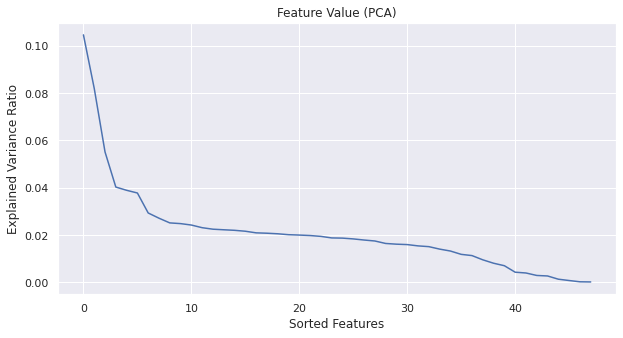

In [970]:
figure(figsize=(10,5))
title("Feature Value (PCA)")
ylabel("Explained Variance Ratio")
xlabel("Sorted Features")
plot(pca.explained_variance_ratio_);

Now we'll use Lasso regression (L1 penalty) to identify features to use when training a classifier.

In [1137]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(X_train, np.ravel(y_train,order='C'))
#sel_.get_support()
#X_train = pd.DataFrame(X_train)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [1138]:
names = mldf.columns.to_numpy()
selection = sel_.get_support()
#print(names, selection)

In [1008]:
print("dropped columns:")
for i in range(len(names)):
    if not selection[i]:
        print(names[i])

dropped columns:
)
``


In [1060]:
X_norm_cleaned = np.delete(X_norm, ~selection, axis=1)
X_norm_cleaned.shape

(2459, 46)

We will now visualize 2D UMAP projections of these two feature spaces to get a feel for how well the separate the data classes.

In [1061]:
umap_2d = UMAP(random_state=0)
umap_2d.fit(X_norm_cleaned)
projections = umap_2d.transform(X_norm_cleaned)

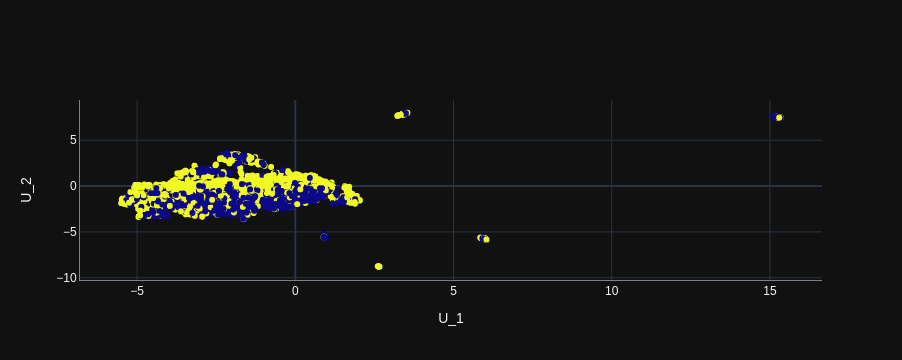

In [1062]:
layout = dict(xaxis=dict(title='U_1',
                         linecolor='gray',
                         showgrid=True,
                         ),
              yaxis=dict(title='U_2',
                         linecolor='gray',
                         showgrid=True,
                         ),
)
data = go.Scatter(x=projections[:,0],
                  y=projections[:,1],
                  #
                  #hovertemplate='Issue %{hovertext}',
                  textposition='top right',
                  mode='markers+text',
                  marker=dict(color=y),#, size=log(all["totals"]), symbol=all["bechdel_binary"]),
                  #hovertext=all[["issue"]].astype(str),
                  #name='Issues',
                  #showlegend=True,
                  )

fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    hoverlabel_align = 'right',)
    #title = "Issue feature similarity embedding")

fig.layout.template = 'plotly_dark'
fig.show()
#fig.write_html()

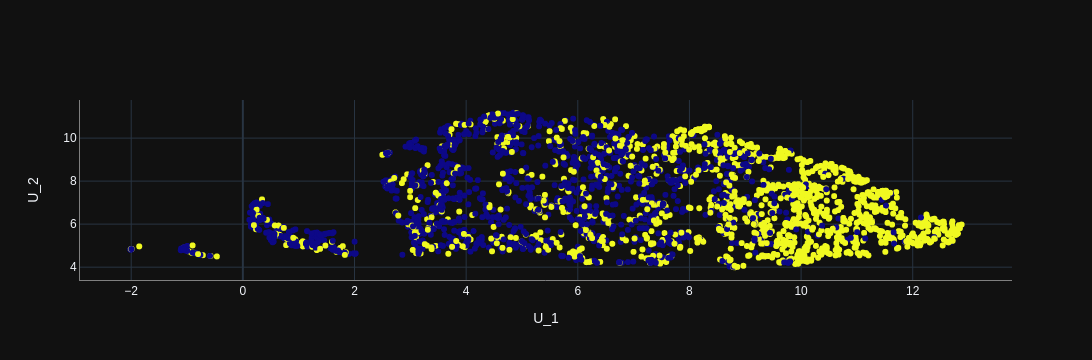

In [1109]:
umap_2d = UMAP(random_state=0)
umap_2d.fit(X_CF_norm)
projections = umap_2d.transform(X_CF_norm)
layout = dict(xaxis=dict(title='U_1',
                         linecolor='gray',
                         showgrid=True,
                         ),
              yaxis=dict(title='U_2',
                         linecolor='gray',
                         showgrid=True,
                         ),
)
data = go.Scatter(x=projections[:,0],
                  y=projections[:,1],
                  #
                  #hovertemplate='Issue %{hovertext}',
                  textposition='top right',
                  mode='markers+text',
                  marker=dict(color=y),#, size=log(all["totals"]), symbol=all["bechdel_binary"]),
                  #hovertext=all[["issue"]].astype(str),
                  #name='Issues',
                  #showlegend=True,
                  )

fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    hoverlabel_align = 'right',)
    #title = "Issue feature similarity embedding")

fig.layout.template = 'plotly_dark'
fig.show()
#fig.write_html()

This latter plot (of the highly correlated features) is much more promising.

Now we'll create feature vectors for the individual readability metrics.

In [1080]:
X_Flesch = df["Flesch Score p100"].to_numpy()
fscalar = StandardScaler()
X_Flesch_norm = fscalar.fit_transform(X_Flesch.reshape(-1, 1))
X_FleschK = df["Flesch-Kincaid Score p100"].to_numpy()
fkscalar = StandardScaler()
X_FleschK_norm = fkscalar.fit_transform(X_FleschK.reshape(-1, 1))
X_LW = df["Linsear Write Score p100"].to_numpy()
lwscalar = StandardScaler()
X_LW_norm = lwscalar.fit_transform(X_LW.reshape(-1, 1))
X_DC = df["Dale-Chall Score p100"].to_numpy()
dcscalar = StandardScaler()
X_DC_norm = dcscalar.fit_transform(X_DC.reshape(-1, 1))
X_S = df["Spache Score p100"].to_numpy()
sscalar = StandardScaler()
X_S_norm = sscalar.fit_transform(X_S.reshape(-1, 1))
X_ARI = df["ARI Score p100"].to_numpy()
ariscalar = StandardScaler()
X_ARI_norm = ariscalar.fit_transform(X_ARI.reshape(-1, 1))

If we were interested genuinely in training a classifier, we would now do a test-train split.

In [1113]:
(X_train, 
 X_test,
 X_CF_train,
 X_CF_test,
 X_Flesch_train,
 X_Flesch_test,
 X_FleschK_train,
 X_FleschK_test,
 X_LW_train,
 X_LW_test,
 X_DC_train,
 X_DC_test,
 X_S_train,
 X_S_test,
 X_ARI_train,
 X_ARI_test,
 y_train, 
 y_test,
) = train_test_split(X_norm_cleaned, 
                     X_CF_norm,
                     X_Flesch_norm,
                     X_FleschK_norm,
                     X_LW_norm,
                     X_DC_norm,
                     X_S_norm,
                     X_ARI_norm,
                     y,
                     test_size=0.01, 
                     random_state=0)

Now we will use 10-fold cross validation to show how well each classifier would perform on the dataset.

In [1134]:
feature_set_names = {"Lasso Features": X_train, 
                     "Highly Correlated Features": X_CF_train, 
                     "Flesch Score": X_Flesch_train,
                     "Flesch-Kincaid Score": X_FleschK_train,
                     "Linseare Write Score":  X_LW_train,
                     "Dale-Chall Score":  X_DC_train,
                     "Spache Score":  X_S_train,
                     "ARI Score":  X_ARI_train,
                    }
total_feature_set_names = {"Lasso Features": X_norm_cleaned, 
                     "Highly Correlated Features": X_CF_norm, 
                     "Flesch Score": X_Flesch_norm,
                     "Flesch-Kincaid Score": X_FleschK_norm,
                     "Linseare Write Score":  X_LW_norm,
                     "Dale-Chall Score":  X_DC_norm,
                     "Spache Score":  X_S_norm,
                     "ARI Score":  X_ARI_norm,
                    }

In [1135]:
cf_scores = pd.DataFrame()
cfname, cfscore = [], []
for feature_set in feature_set_names:
    cfname.append(feature_set)
    clf = GaussianNB()
    cfscore.append(cross_val_score(clf, feature_set_names[feature_set], y_train, cv=10).mean())
cf_scores["Feature Set"] = cfname
cf_scores["Mean 10-Fold Cross-Validation Accuracy Score"] = cfscore
print("Training Cross-Validation Results")
cf_scores.sort_values(by="Mean 10-Fold Cross-Validation Accuracy Score", ascending=False)

Training Cross-Validation Results


,Feature Set,Mean 10-Fold Cross-Validation Accuracy Score
1,Highly Correlated Features,0.756790
3,Flesch-Kincaid Score,0.730478
7,ARI Score,0.729646
4,Linseare Write Score,0.720195
6,Spache Score,0.718537
2,Flesch Score,0.709529
5,Dale-Chall Score,0.656507
0,Lasso Features,0.623212


In [1136]:
cf_scores = pd.DataFrame()
cfname, cfscore = [], []
for feature_set in total_feature_set_names:
    cfname.append(feature_set)
    clf = GaussianNB()
    cfscore.append(cross_val_score(clf, total_feature_set_names[feature_set], y, cv=10).mean())
cf_scores["Feature Set"] = cfname
cf_scores["Mean 10-Fold Cross-Validation Accuracy Score"] = cfscore
print("Training Cross-Validation Results")
cf_scores.sort_values(by="Mean 10-Fold Cross-Validation Accuracy Score", ascending=False)

Training Cross-Validation Results


,Feature Set,Mean 10-Fold Cross-Validation Accuracy Score
1,Highly Correlated Features,0.753149
7,ARI Score,0.727531
4,Linseare Write Score,0.725089
3,Flesch-Kincaid Score,0.723874
6,Spache Score,0.716536
2,Flesch Score,0.708815
5,Dale-Chall Score,0.656773
0,Lasso Features,0.612851
